In [20]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("spam.csv", encoding="latin-1")
df = df.rename(columns={df.columns[0]: "Category", df.columns[1]: "Message"})
df = df[['Category','Message']]

df['label'] = df['Category'].map({'ham':0, 'spam':1})

X = df['Message']
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

# Train sklearn models
nb = MultinomialNB().fit(X_train_tfidf, y_train)
lr = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train)
svm = LinearSVC().fit(X_train_tfidf, y_train)

print("Sklearn models trained.")


Training samples: 4458
Test samples: 1115
TF-IDF train shape: (4458, 7413)
TF-IDF test shape: (1115, 7413)
Sklearn models trained.


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print("Tokenizer and padded sequences ready.")


Tokenizer and padded sequences ready.


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

EMB_DIM = 64

# ANN Model
ann = Sequential([
    Embedding(MAX_WORDS, EMB_DIM, input_length=MAX_LEN),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training ANN...")
ann.fit(X_train_pad, y_train, epochs=5, batch_size=64,
        validation_split=0.1, verbose=1)

# CNN Model
cnn = Sequential([
    Embedding(MAX_WORDS, EMB_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nTraining CNN...")
cnn.fit(X_train_pad, y_train, epochs=5, batch_size=64,
        validation_split=0.1, verbose=1)


Training ANN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8682 - loss: 0.4336 - val_accuracy: 0.8453 - val_loss: 0.4021
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8728 - loss: 0.3631 - val_accuracy: 0.8453 - val_loss: 0.3952
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8728 - loss: 0.3591 - val_accuracy: 0.8453 - val_loss: 0.3843
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8728 - loss: 0.3457 - val_accuracy: 0.8453 - val_loss: 0.3589
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8728 - loss: 0.3159 - val_accuracy: 0.8453 - val_loss: 0.2991

Training CNN...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8323 - loss: 0.5012 - val_accuracy: 0.8453 - val_loss: 0.3690
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8851 - loss: 0.2607 - val_accuracy: 0.9753 - val_loss: 0.0635
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9910 - loss: 0.0383 - val_accuracy:

 MODEL: Multinomial Naive Bayes
Accuracy : 97.85%
Precision: 100.00%
Recall   : 84.00%
F1-score : 91.30%

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       1.00      0.84      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[965   0]
 [ 24 126]]


 MODEL: Logistic Regression
Accuracy : 97.13%
Precision: 100.00%
Recall   : 78.67%
F1-score : 88.06%

Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
[[965   0]
 [ 32 118]]


 MODEL

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8669 - loss: 0.4554
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8734 - loss: 0.2893
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.1013
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9897 - loss: 0.0445
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9943 - loss: 0.0257
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training CNN model...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8584 - loss: 0.4587
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9825 - loss: 0.0611
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9962 - loss: 0.0151
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9986 - loss: 0.0070
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9994 - loss: 0.0036
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

======= MODEL COMPARISON TABLE =======
                     model  accuracy  precision    recall        f1
0  Multinomial Naive Bayes  0.978475   1.000000  0.840000  0.913043
1      Logistic Regression  0.971300   1.000000  0.786667  0.880597
2   Linear SVM (LinearSVC)  0.982960   0.992481  0.880000  0.932862
3     ANN (Neural Network)  0.989238   0.992857  0.926667  0.958621
4     CNN (1D Convolution)  0.983857   0.945946  0.933333  0.939597 



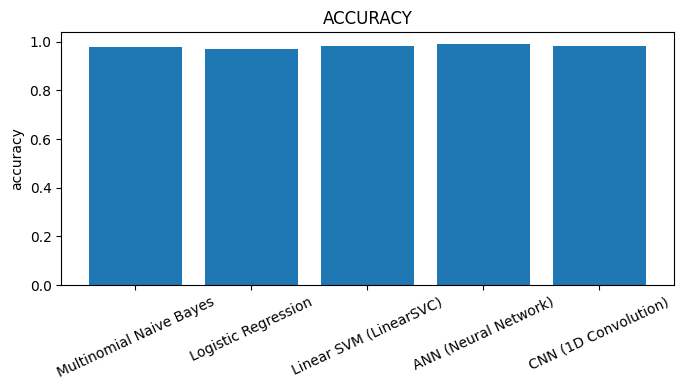

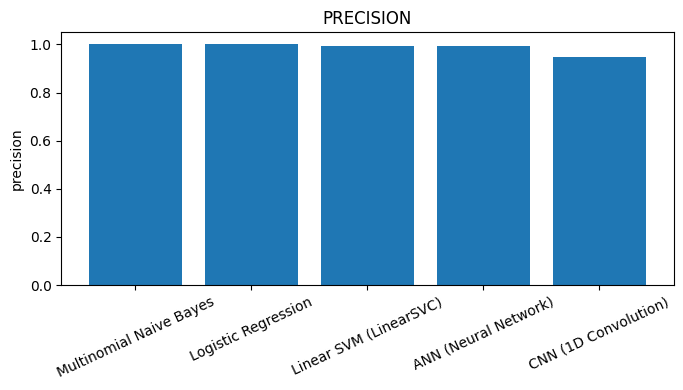

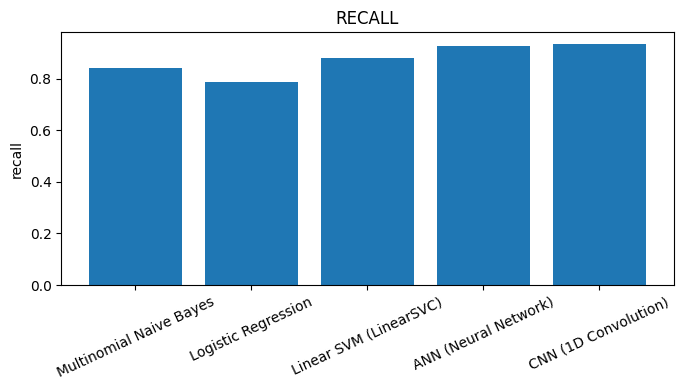

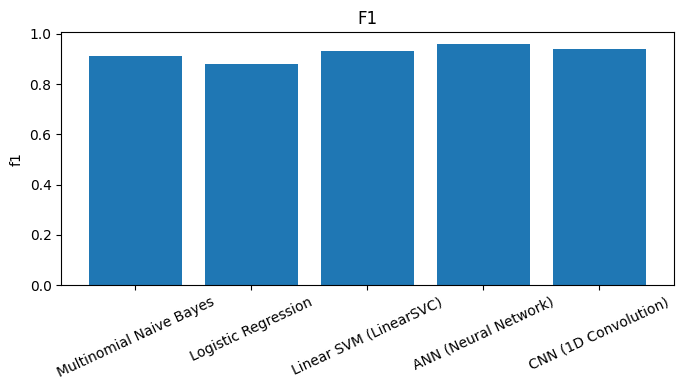

======= SAMPLE PREDICTIONS =======

Message: Congratulations! You've won a FREE prize!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
{'NaiveBayes': 'SPAM', 'LogisticRegression': 'SPAM', 'SVM': 'SPAM', 'ANN': 'SPAM', 'CNN': 'SPAM'}

Message: Are we meeting today?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
{'NaiveBayes': 'HAM', 'LogisticRegression': 'HAM', 'SVM': 'HAM', 'ANN': 'HAM', 'CNN': 'HAM'}

Message: Your account is locked. Verify now!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
{'NaiveBayes': 'HAM', 'LogisticRegression': 'HAM', 'SVM': 'HAM', 'ANN': 'SPAM', 'CNN': 'SPAM'}

Message: Call me later please.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
{'NaiveBayes': 'HAM', 'LogisticRegression': 'HAM', 'SVM': 'HAM', 'ANN': 'HAM', 'CNN': 'HAM'}


In [23]:
# ==========================================================
# SPAM EMAIL DETECTION – 5 MODELS
# Naive Bayes, Logistic Regression, SVM, ANN, CNN
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# ================================================
# 1. LOAD DATASET
# ================================================

df = pd.read_csv("spam.csv")

df = df[['Category', 'Message']]
df.dropna(subset=['Category', 'Message'], inplace=True)

df["label"] = df["Category"].map({"ham": 0, "spam": 1})

X = df["Message"]
y = df["label"]

# ================================================
# 2. TRAIN–TEST SPLIT
# ================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================================
# 3. TF-IDF (for NB, LR, SVM)
# ================================================
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# ============================================================
# FUNCTION: TRAIN + EVALUATE CLASSICAL ML
# ============================================================
def train_and_evaluate(model, model_name):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("==============================================")
    print(f" MODEL: {model_name}")
    print("==============================================")
    print(f"Accuracy : {acc*100:.2f}%")
    print(f"Precision: {prec*100:.2f}%")
    print(f"Recall   : {rec*100:.2f}%")
    print(f"F1-score : {f1*100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["ham", "spam"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    return {"model": model_name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# ================================================
# 4. TRAIN CLASSICAL MODELS
# ================================================
results = []

nb_model     = MultinomialNB(alpha=0.5)
log_reg_model = LogisticRegression(max_iter=1000)
svm_model     = LinearSVC()

results.append(train_and_evaluate(nb_model, "Multinomial Naive Bayes"))
results.append(train_and_evaluate(log_reg_model, "Logistic Regression"))
results.append(train_and_evaluate(svm_model, "Linear SVM (LinearSVC)"))

# ============================================================
# 5. ANN & CNN MODELS (TOKENIZER + SEQUENCES)
# ============================================================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout

MAX_VOCAB = 5000
MAX_LEN = 120

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

# ============================================================
# ANN MODEL
# ============================================================
ann = Sequential([
    Embedding(MAX_VOCAB, 32, input_length=MAX_LEN),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training ANN model...")
ann.fit(X_train_pad, y_train, epochs=5, batch_size=32, verbose=1)

ann_pred = (ann.predict(X_test_pad) > 0.5).astype("int32").flatten()
ann_acc = accuracy_score(y_test, ann_pred)
ann_prec = precision_score(y_test, ann_pred)
ann_rec = recall_score(y_test, ann_pred)
ann_f1 = f1_score(y_test, ann_pred)

results.append({
    "model": "ANN (Neural Network)",
    "accuracy": ann_acc,
    "precision": ann_prec,
    "recall": ann_rec,
    "f1": ann_f1
})

# ============================================================
# CNN MODEL
# ============================================================
cnn = Sequential([
    Embedding(MAX_VOCAB, 64, input_length=MAX_LEN),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Training CNN model...")
cnn.fit(X_train_pad, y_train, epochs=5, batch_size=32, verbose=1)

cnn_pred = (cnn.predict(X_test_pad) > 0.5).astype("int32").flatten()
cnn_acc = accuracy_score(y_test, cnn_pred)
cnn_prec = precision_score(y_test, cnn_pred)
cnn_rec = recall_score(y_test, cnn_pred)
cnn_f1 = f1_score(y_test, cnn_pred)

results.append({
    "model": "CNN (1D Convolution)",
    "accuracy": cnn_acc,
    "precision": cnn_prec,
    "recall": cnn_rec,
    "f1": cnn_f1
})

# ============================================================
# 6. RESULTS COMPARISON TABLE
# ============================================================
results_df = pd.DataFrame(results)
print("\n======= MODEL COMPARISON TABLE =======")
print(results_df, "\n")

# ============================================================
# 7. GRAPHS
# ============================================================
metrics = ["accuracy", "precision", "recall", "f1"]

for metric in metrics:
    plt.figure(figsize=(7,4))
    plt.bar(results_df["model"], results_df[metric])
    plt.title(metric.upper())
    plt.ylabel(metric)
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

# ============================================================
# 8. CUSTOM PREDICTION (ALL MODELS)
# ============================================================
def predict_message(msg):
    vec = tfidf.transform([msg])
    seq = tokenizer.texts_to_sequences([msg])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')

    return {
        "NaiveBayes": "SPAM" if nb_model.predict(vec)[0] == 1 else "HAM",
        "LogisticRegression": "SPAM" if log_reg_model.predict(vec)[0] == 1 else "HAM",
        "SVM": "SPAM" if svm_model.predict(vec)[0] == 1 else "HAM",
        "ANN": "SPAM" if ann.predict(pad)[0][0] > 0.5 else "HAM",
        "CNN": "SPAM" if cnn.predict(pad)[0][0] > 0.5 else "HAM"
    }

print("======= SAMPLE PREDICTIONS =======")
samples = [
    "Congratulations! You've won a FREE prize!",
    "Are we meeting today?",
    "Your account is locked. Verify now!",
    "Call me later please."
]

for s in samples:
    print("\nMessage:", s)
    print(predict_message(s))


===== CONFUSION MATRICES =====


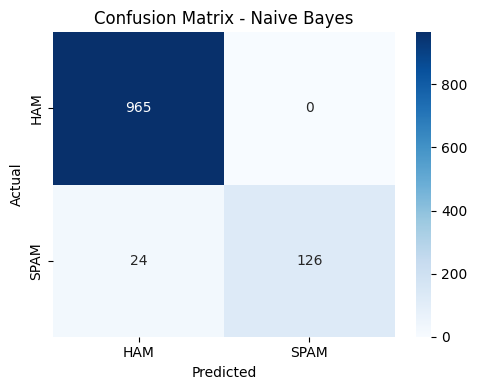

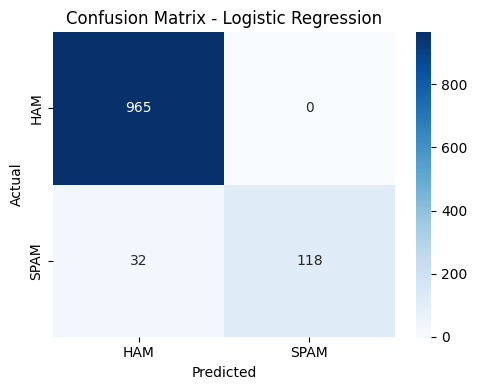

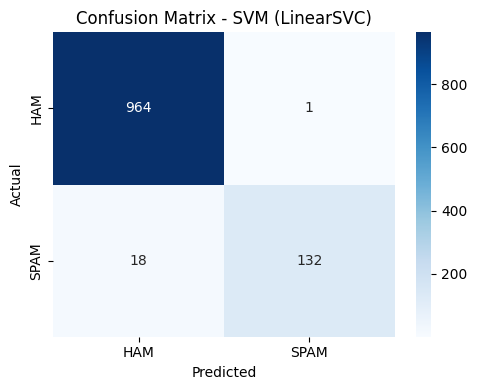

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


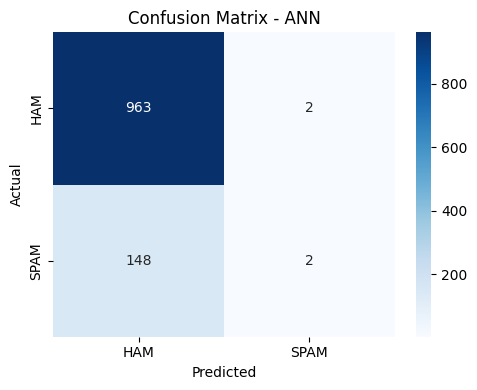

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


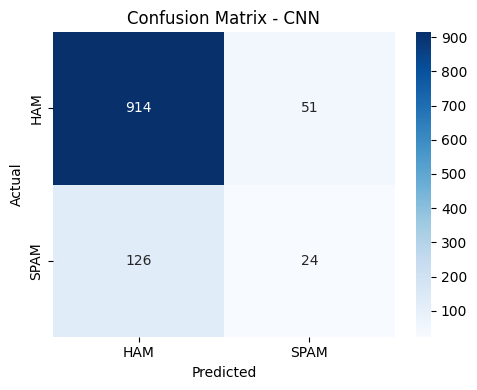

In [29]:
# ============================================================
# 8. CONFUSION MATRIX PLOTS FOR ALL MODELS
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(model, model_name, X_test_features, y_test):
    """Plot confusion matrix with heatmap"""
    y_pred = model.predict(X_test_features)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


print("===== CONFUSION MATRICES =====")

# Classical models
plot_confusion(nb_model, "Naive Bayes", X_test_tfidf, y_test)
plot_confusion(log_reg_model, "Logistic Regression", X_test_tfidf, y_test)
plot_confusion(svm_model, "SVM (LinearSVC)", X_test_tfidf, y_test)

# ANN
ann_pred_classes = (ann.predict(X_test_pad) > 0.5).astype("int32").flatten()
cm_ann = confusion_matrix(y_test, ann_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
plt.title("Confusion Matrix - ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# CNN
cnn_pred_classes = (cnn.predict(X_test_pad) > 0.5).astype("int32").flatten()
cm_cnn = confusion_matrix(y_test, cnn_pred_classes)
plt.figure(figsize=(5,4))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
